# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [18]:
import os
print(os.getcwd())

/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/test/c3


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:

os.chdir('/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/test/c3')
print(os.listdir()[0:10])

['motorbike_0592.jpg', 'motorbike_0593.jpg', 'motorbike_0594.jpg', 'motorbike_0595.jpg', 'motorbike_0596.jpg', 'motorbike_0597.jpg', 'motorbike_0598.jpg', 'motorbike_0599.jpg', 'motorbike_0600.jpg', 'motorbike_0601.jpg']


In [19]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [6]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.915958681999996
GPU (s):
0.0500925000000052
GPU speedup over CPU: 58x


In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import tensorflow.keras as keras
import cv2
import numpy
import os
import matplotlib.pyplot as plt

In [28]:
def loadtrain():
    l=['/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/train/c0','/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/train/c1'
       ,'/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/train/c2','/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/train/c3']
    train_data=[]
    train_label=[]
    for x in range(4):
        os.chdir(l[x])
        ggg=0
        img_list=os.listdir()
        for file in img_list:
            ggg=ggg+1
            img=cv2.imread(file)
            img2 = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            train_data.append(img2)
            label=numpy.zeros(4,)
            label[x]=1
            train_label.append(label)
            if ggg%50==0:
              print(ggg)
        print(x)
    train_label=numpy.array(train_label)
    train_label=numpy.float32(train_label)
    train_data=numpy.array(train_data)
    train_data=numpy.float32(train_data)
    train_data=(train_data-128)/128
    return train_data, train_label

train_data,train_label = loadtrain()


50
100
150
200
250
300
350
400
0
50
100
150
200
250
300
350
1
50
100
150
200
250
300
350
400
450
2
50
100
150
200
250
300
350
3


In [7]:
train_data.shape

(1675, 128, 128, 3)

In [0]:
def loadval():
    l=['/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/val/c0','/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/val/c1'
       ,'/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/val/c2','/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/val/c3']
    val_data = []
    val_label = []
    for x in range(4):
        os.chdir(l[x])
        img_list = os.listdir()
        for file in img_list:
            img = cv2.imread(file)
            img2 = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            val_data.append(img2)
            label = numpy.zeros(4, )
            label[x] = 1
            val_label.append(label)
    val_data=numpy.array(val_data)
    val_label=numpy.array(val_label)
    val_data=numpy.float32(val_data)
    val_data=(val_data-128)/128
    val_label=numpy.float32(val_label)
    return val_data, val_label

val_data,val_label = loadval()

In [0]:
def augment(data,label):
    lis1,lis2=[],[]
    l=data.shape[0]
    for i in range(l):
        img=data[i]
        lab=label[i]
        #img2=cv2.flip(img,0)
        img3=cv2.flip(img,1)
        lis1=lis1+[img,img3]
        lis2=lis2+[lab,lab]
    lis1=numpy.array(lis1)
    lis2=numpy.array(lis2)
    lis1=numpy.float32(lis1)
    lis2=numpy.float32(lis2)
    return lis1,lis2


In [0]:
def transfer_learning_with_vggnet():
    """Return model built on pre-trained VGG16."""
    #######
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3))
    for layer in base_model.layers:
        layer.trainable = False
    mod =models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512),
        layers.Activation('relu'),
        layers.Dense(4),
        layers.Activation('softmax'),
    ])
    #######
    return mod

In [53]:
model = transfer_learning_with_vggnet()
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               4194816   
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 2052      
_________________________________________________________________
activation_11 (Activation)   (None, 4)                 0         
Total params: 24,221,252
Trainable params: 4,196,868
No

Epoch 1/10
252/252 [==============================] - 8s 30ms/step - loss: 0.3859 - accuracy: 0.9244 - val_loss: 0.0780 - val_accuracy: 0.9677
Epoch 2/10
252/252 [==============================] - 7s 28ms/step - loss: 0.1006 - accuracy: 0.9698 - val_loss: 0.6909 - val_accuracy: 0.8754
Epoch 3/10
252/252 [==============================] - 7s 29ms/step - loss: 0.0610 - accuracy: 0.9821 - val_loss: 0.2162 - val_accuracy: 0.9557
Epoch 4/10
252/252 [==============================] - 7s 28ms/step - loss: 0.0451 - accuracy: 0.9899 - val_loss: 0.2849 - val_accuracy: 0.9545
Epoch 5/10
252/252 [==============================] - 7s 28ms/step - loss: 0.0284 - accuracy: 0.9916 - val_loss: 0.2228 - val_accuracy: 0.9653
Epoch 6/10
252/252 [==============================] - 7s 29ms/step - loss: 0.0256 - accuracy: 0.9946 - val_loss: 0.2818 - val_accuracy: 0.9677
Epoch 7/10
252/252 [==============================] - 7s 29ms/step - loss: 0.0163 - accuracy: 0.9960 - val_loss: 0.3362 - val_accuracy: 0.9665

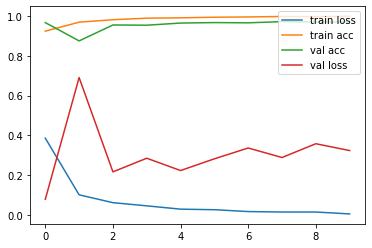

In [34]:
model = transfer_learning_with_vggnet()
with tf.device('/device:GPU:0'):
    
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    train_data, train_label = augment(train_data,train_label)


    history = model.fit(train_data, train_label,
                        batch_size=20, epochs=10, shuffle=True,
                        validation_data=(val_data, val_label))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend(loc="upper right")
    plt.show()

Epoch 1/10
84/84 [==============================] - 3s 38ms/step - loss: 0.1722 - accuracy: 0.9636 - val_loss: 0.1964 - val_accuracy: 0.9653
Epoch 2/10
84/84 [==============================] - 3s 36ms/step - loss: 0.0798 - accuracy: 0.9845 - val_loss: 0.1227 - val_accuracy: 0.9796
Epoch 3/10
84/84 [==============================] - 3s 36ms/step - loss: 0.0546 - accuracy: 0.9922 - val_loss: 0.3763 - val_accuracy: 0.9545
Epoch 4/10
84/84 [==============================] - 3s 37ms/step - loss: 0.0126 - accuracy: 0.9976 - val_loss: 0.1525 - val_accuracy: 0.9737
Epoch 5/10
84/84 [==============================] - 3s 36ms/step - loss: 0.0589 - accuracy: 0.9946 - val_loss: 0.4649 - val_accuracy: 0.9449
Epoch 6/10
84/84 [==============================] - 3s 36ms/step - loss: 0.0267 - accuracy: 0.9970 - val_loss: 0.2548 - val_accuracy: 0.9677
Epoch 7/10
84/84 [==============================] - 3s 36ms/step - loss: 1.0473e-05 - accuracy: 1.0000 - val_loss: 0.2841 - val_accuracy: 0.9617
Epoch 8/1

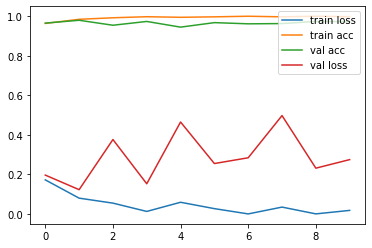

In [33]:
with tf.device('/device:GPU:0'):
    
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    #train_data, train_label = augment(train_data,train_label)


    history = model.fit(train_data, train_label,
                        batch_size=20, epochs=10, shuffle=True,
                        validation_data=(val_data, val_label))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend(loc="upper right")
    plt.show()

In [0]:
def aug2(data,label):
    lis1, lis2 = [], []
    l = data.shape[0]
    for i in range(l):
        img=data[i]
        lab=label[i]
        img0 = cv2.resize(img, dsize=(136, 136), interpolation=cv2.INTER_CUBIC)
        img1=img0[0:128,0:128]
        img2=img0[0:128,6:134]
        img3=img0[6:134,0:128]
        img4=img0[6:134,6:134]

        lis1=lis1+[img,img1,img2,img3,img4]
        lis2=lis2+[lab,lab,lab,lab,lab]
    lis1=numpy.array(lis1)
    lis2=numpy.array(lis2)
    #lis1=numpy.float32(lis1)
    #lis2=numpy.float32(lis2)
    return lis1,lis2

In [37]:
train_data.shape

(1675, 128, 128, 3)

In [0]:
train_data5,train_label5=aug2(train_data,train_label)

In [45]:
train_data5.dtype

dtype('float32')

Epoch 1/10
628/628 [==============================] - 103s 164ms/step - loss: 0.0586 - accuracy: 0.9836
Epoch 2/10
628/628 [==============================] - 103s 164ms/step - loss: 0.0036 - accuracy: 0.9989
Epoch 3/10
628/628 [==============================] - 103s 163ms/step - loss: 0.0090 - accuracy: 0.9973
Epoch 4/10
628/628 [==============================] - 103s 164ms/step - loss: 0.0044 - accuracy: 0.9984
Epoch 5/10
628/628 [==============================] - 103s 163ms/step - loss: 0.0011 - accuracy: 0.9996
Epoch 6/10
628/628 [==============================] - 103s 164ms/step - loss: 0.0139 - accuracy: 0.9961
Epoch 7/10
628/628 [==============================] - 103s 164ms/step - loss: 8.2718e-04 - accuracy: 0.9998
Epoch 8/10
628/628 [==============================] - 103s 164ms/step - loss: 1.7472e-04 - accuracy: 1.0000
Epoch 9/10
628/628 [==============================] - 103s 163ms/step - loss: 5.3479e-06 - accuracy: 1.0000
Epoch 10/10
628/628 [==============================]

KeyError: ignored

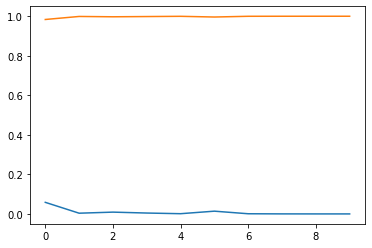

In [56]:
with tf.device('/device:GPU:0'):
    model2 = transfer_learning_with_vggnet()
    model2.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=['accuracy'])
    train_data5, train_label5 = augment(train_data,train_label)
    train_data5, train_label5 = aug2(train_data5,train_label5)
    val_data5, val_label5 = augment(val_data,val_label)
    val_data5,val_label5=aug2(val_data5,val_label5)
    train_data5=numpy.concatenate((train_data5,val_data5))
    train_label5=numpy.concatenate((train_label5,val_label5))
    history = model2.fit(train_data5, train_label5,
                        batch_size=40, epochs=10, shuffle=True)
                        #validation_data=(val_data, val_label))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend(loc="upper right")
    plt.show()

In [57]:

model2.evaluate(tdata,tlabel)

7/7 [==============================] - 1s 96ms/step - loss: 0.1890 - accuracy: 0.9750


[0.18897958099842072, 0.9750000238418579]

In [0]:
model2.save('all_no_vertical.h5')

In [0]:
os.chdir('/content/drive/My Drive')

In [83]:
new_model = keras.models.load_model('all_no_vertical.h5')
vd,vl=aug2(tdata,tlabel)
new_model.evaluate(tdata,tlabel)

7/7 [==============================] - 1s 80ms/step - loss: 0.0578 - accuracy: 0.9850


[0.057782091200351715, 0.9850000143051147]

In [70]:
def loadtest():
    l=['/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/test/c0','/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/test/c1','/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/test/c2','/content/drive/My Drive/cat_dog_car_bike.zip (Unzipped Files)/cat_dog_car_bike/test/c3']
    train_data=[]
    train_label=[]
    for x in range(4):
        os.chdir(l[x])
        ggg=0
        img_list=os.listdir()
        for file in img_list:
            ggg=ggg+1
            img=cv2.imread(file)
            img2 = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            train_data.append(img2)
            label=numpy.zeros(4,)
            label[x]=1
            train_label.append(label)
            if ggg%50==0:
              print(ggg)
        print(x)
    train_label=numpy.array(train_label)
    train_label=numpy.float32(train_label)
    train_data=numpy.array(train_data)
    train_data=numpy.float32(train_data)
    train_data=(train_data-128)/128
    return train_data, train_label

tdata,tlabel = loadtest()

50
0
50
1
50
2
50
3


In [71]:
tdata.shape


(200, 128, 128, 3)